In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *
from functions.helpers import organise_data, prcnt_hft_trading, all_sharpe, sharpe

# Benchmark scenario
To start to get a feel for the model dynamics, I start with a simple benchmark scenario with a single HFM $N_{h} = 1$ and , where the fundamental is stationary $\sigma^f = 0$, and where there are no chartist LFTs $\sigma^{wc} = 0$.

In [2]:
NRUNS = 5

In [3]:
# 1 setup parameters
parameters = {
    # global parameters
    "n_lft": 100,
    "n_hft": 1,
    "ticks": 1000, # 390 ticks per day
    "ticks_per_minute": 1,
    "fundamental_value": 10,
    "std_fundamental": 0.0,
    "lft_sample_size": 0.03,
    "hft_sample_size": 1.0,
    "std_noise": 0.01,
    "std_LFT_vol": 1,
    "std_HFT_vol": 4,
    "max_order_expiration_ticks": 30,
    "transaction_fee": 0.0,
    "max_spread_exchange": 0.01,
    # lft parameters
    "w_fundamentalists": 1.0, #1
    "w_chartists": 0.0, # 10
    "w_random": 4.0,
    "spread_max": 0.004087, # from Riordann & Storkenmaier 2012
    # hft parameters
    "inventory_target": 10,
    "minimum_price_increment": 0.001,
    "hfm_risk_aversion": 0.01,
    "hfm_adaptive_param": 0.2,
    "hfm_volatility_sensitivity": 1.9,
    # initial values
    "horizon_min": 1,
    "horizon_max": 9,
    "hfm_horizon_min": 1,
    "hfm_horizon_max": 5,
    "total_hft_money": 250,
    "hft_speed": 1,
}

## 1 Baseline simulations

In [4]:
hfms = []
lfts = []
obs = []
for seed in range(NRUNS): # optional, remove tqdm(), it is used for the progress bar
    print('seed is ', seed)
    high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)
    hft, lft, ob = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)
    hfms.append(hft)
    lfts.append(lft)
    obs.append(ob)

seed is  0
tick:  250
tick:  500
tick:  750
seed is  1
tick:  250
tick:  500
tick:  750
seed is  2
tick:  250
tick:  500
tick:  750
seed is  3
tick:  250
tick:  500
tick:  750
seed is  4
tick:  250
tick:  500
tick:  750


In [5]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

### a Prices, Returns & Volume

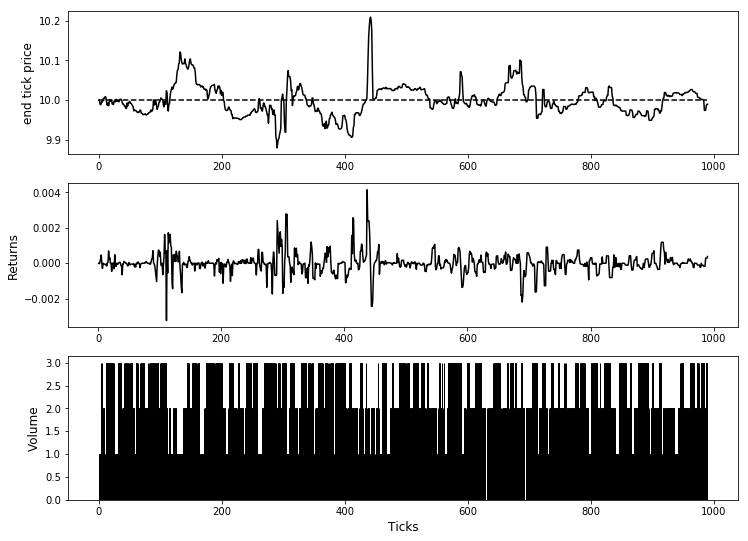

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.median(axis=1), 'k-', label='close price')
ax1.set_ylabel('end tick price', fontsize='12')
#ax1.legend()

ax2.plot(mc_returns.index, mc_returns.median(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.bar(mc_volume.index, mc_volume.median(axis=1), color='k', edgecolor='k')
ax3.set_ylabel('Volume', fontsize='12')
ax3.set_xlabel('Ticks', fontsize='12')

#fig.savefig('benchmark_baseline_dynamics.png')

### b HFM profitability

In [57]:
percentage_trades_hfm = [prcnt_hft_trading(ob) for ob in obs]
np.mean(percentage_trades_hfm)

0.57327771589753607

In [8]:
all_s = [all_sharpe(h) for h in hfms]
np.mean(all_s)

20.15744356401499

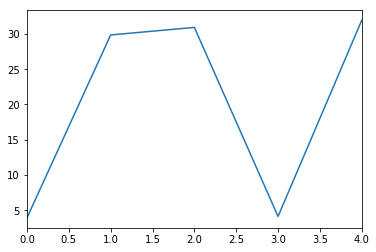

In [9]:
pd.Series(all_s).plot()

### c HFM quotes
Every tick, collect:
* bid-quote-price
* bid-quote-volume
* ask-quote-price
* ask-quote-volume

In [10]:
bid_quotes = [h[0].var_previous.bid_quote for h in hfms]
ask_quotes = [h[0].var_previous.ask_quote for h in hfms]
bid_volume = [h[0].var_previous.bid_quote_volume for h in hfms]
ask_volume = [h[0].var_previous.ask_quote_volume for h in hfms]

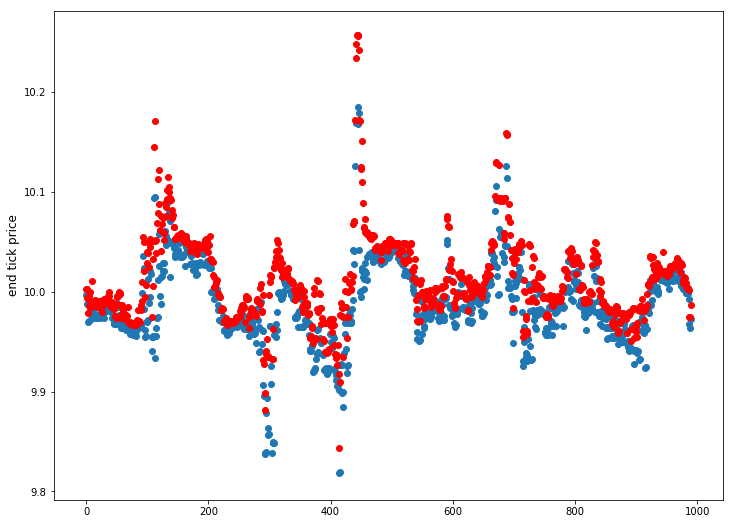

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,9))

#ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
#ax1.plot(mc_prices.index, mc_prices.median(axis=1), 'k-', label='close price')
ax1.set_ylabel('end tick price', fontsize='12')

ax1.scatter(pd.Series(bid_quotes[0]).index, pd.Series(bid_quotes[0]))
ax1.scatter(pd.Series(ask_quotes[0]).index, pd.Series(ask_quotes[0]), color='r')

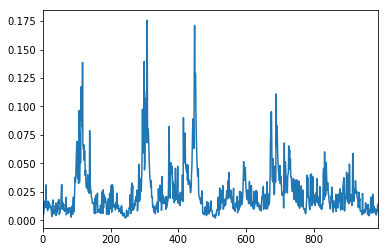

In [13]:
pd.Series(np.array(np.array(ask_quotes[0]) - bid_quotes[0])).plot()

In [14]:
bid_ask = bid_ask = [((ask - bid) / np.mean([ask, bid])) / 2 for bid, ask in zip(orderbook.highest_bid_price_history, orderbook.lowest_ask_price_history)]
bid_ask = list(filter(lambda x: x >0, bid_ask))

### HFM profitability

In [15]:
money = []
stocks = []
locked_in_profits = []
for hft in high_frequency_traders:
    money.append(np.array(hft.var_previous.money))
    stocks.append(np.array(hft.var_previous.stocks))
    locked_in_profits.append(np.array(hft.var_previous.locked_profit))

In [29]:
stocks_worth = stocks[0] * np.array(orderbook.tick_close_price)
wealth = stocks_worth + money[0]

In [46]:
#stocks[0] - np.ones
inventory_deviation_from_target = stocks[0] - (np.zeros(len(stocks[0])) + 10)

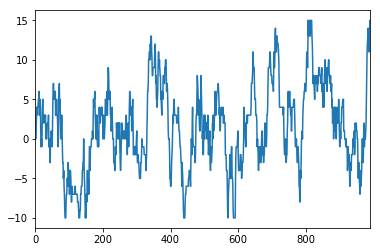

In [48]:
pd.Series(inventory_deviation_from_target).plot()

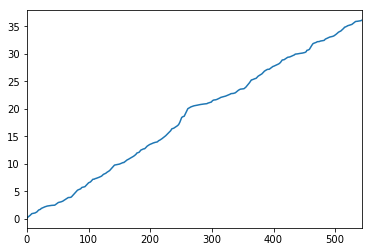

In [16]:
pd.Series(np.cumsum(locked_in_profits[0])).plot()

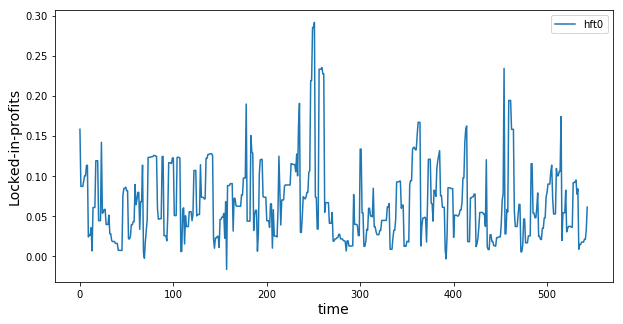

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, p in enumerate(locked_in_profits):
    ax1.plot(range(len(p)), p, label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Locked-in-profits', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

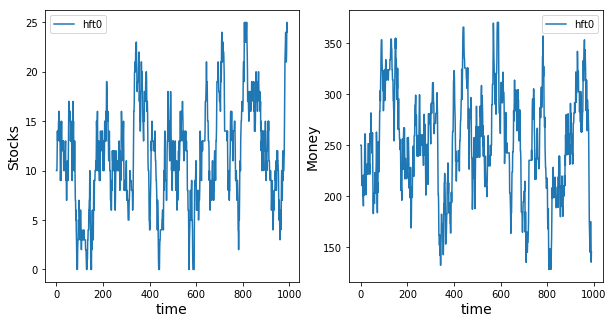

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

timeframe = 10000

for idx, s in enumerate(stocks):
    ax1.plot(range(len(s[:timeframe])), s[:timeframe], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Stocks', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

for idx, m in enumerate(money):
    ax2.plot(range(len(m[:timeframe])), m[:timeframe], label='hft{}'.format(idx))

ax2.legend(frameon=True, loc='best', framealpha=0.8)
ax2.set_ylabel('Money', fontsize='14')
ax2.set_xlabel('time', fontsize='14')

### Summary

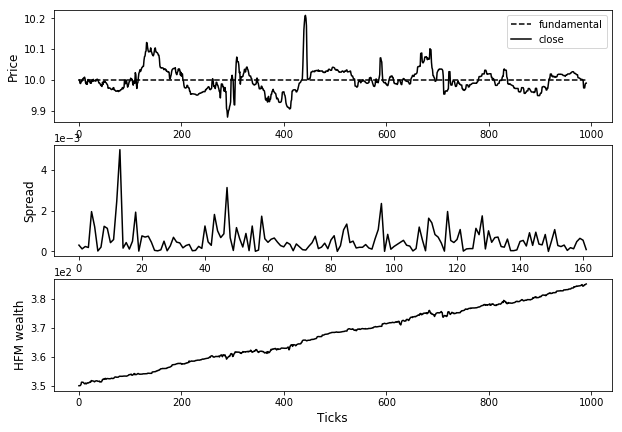

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,7))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental')
ax1.plot(mc_prices.index, mc_prices.median(axis=1), 'k-', label='close')
ax1.set_ylabel('Price', fontsize='12')
ax1.legend()

ax2.plot(pd.Series(bid_ask).index, pd.Series(bid_ask), 'k-')
ax2.set_ylabel('Spread', fontsize='12')

ax3.plot(range(len(wealth)), wealth, 'k-')
ax3.set_ylabel('HFM wealth', fontsize='12')
ax3.set_xlabel('Ticks', fontsize='12')


for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

fig.savefig('benchmark_baseline_dynamics.png')

### d Autocorrelation of returns

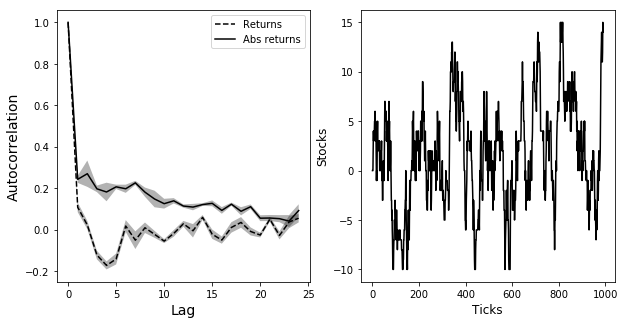

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='Abs returns')
ax1.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax2.plot(range(len(inventory_deviation_from_target)), inventory_deviation_from_target, 'k-', label='deviation from target')
ax2.set_ylabel('Stocks', fontsize='12')
ax2.set_xlabel('Ticks', fontsize='12')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

fig.savefig('benchmark_stylized_facts.png')

## 2 Experiment no HFM vs HFM
Impact on: 
* spreads
* orderbook depth around the mid point.
* orderbook balance (increase)

## 3 Experiment increase HFM speed
Impact on:
* HFM profits 
* spreads? 